# How to set the Operating Point
This tutorial explain how to use the object InputCurrent and VarLoadCurrent to run a magnetic simulation on several operating points by setting Id/Iq or I0/Phi0.

The reference used to validate this tutorial is: Z. Yang, M. Krishnamurthy and I. P. Brown, "Electromagnetic and vibrational characteristic of IPM over full torque-speed range," 2013 International Electric Machines & Drives Conference, Chicago, IL, 2013, pp. 295-302, doi: 10.1109/IEMDC.2013.6556267.

# Machine and Simulation definition
This tutorial use the machine IPMSM_A (Prius 2004) defined in the "[How to define a machine](https://pyleecan.org/tuto_Machine.html)" tutorial. The magnetic module is the same as the symmetrical one from the tutorial "[How to define a simulation to call FEMM](https://pyleecan.org/tuto_Simulation_FEMM.html)".

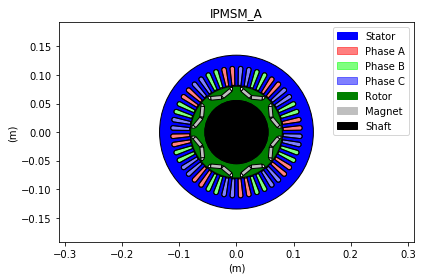

In [1]:
# Change of directory (for import/load)
from os import chdir
from os.path import join
chdir('..')

# Load the machine
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

IPMSM_A = load(join(DATA_DIR, "Machine", "IPMSM_A.json"))
IPMSM_A.plot()

In [2]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
# Initialization of the Simulation
simu = Simu1(name="tuto_Id_Iq", machine=IPMSM_A)

# Definition of the magnetic simulation (FEMM with symmetry and sliding band)
simu.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_symmetry_a=True,
    sym_a = 4,
    is_antiper_a=True,
    Kgeo_fineness=0.75,
)
# Run only Magnetic module
simu.force = None
simu.struct = None

# Defining an Operating point with Id/Iq
The starting point of the simulation is defined with InputCurrent. This object will create an "OutElec" object that correspond to the output of the Electrical module and the input of the Magnetic module. InputCurrent enables to define in several ways the starting point. The tutorial "[How to define a simulation to call FEMM](https://pyleecan.org/tuto_Simulation_FEMM.html)" introduces how to enforce any current by directly setting Is. When the current is sinusoidal, it can be defined with Id_ref and Iq_ref as follow:

In [3]:
from pyleecan.Classes.InputCurrent import InputCurrent
# Definition of a sinusoidal current
simu.input = InputCurrent()
simu.input.Id_ref = -100 # [A]
simu.input.Iq_ref = 200 # [A]


The discretization of the current and for the magnetic computation can be set with time and angle (as in "[How to define a simulation to call FEMM](https://pyleecan.org/tuto_Simulation_FEMM.html)" tutorial) or by setting the following parameters:

In [4]:
simu.input.Nt_tot = 10 # Number of time step
simu.input.Na_tot = 2048 # Spatial discretization
simu.input.N0 = 2000 # Rotor speed [rpm]
simu.input.rot_dir = 1 # To enforce the rotation direction

When Nt_tot is defined, the time vector is automatically set to:

    linspace(0, 60 / N0 * Nrev, Nt_tot)

With Nrev the number of revolution of the rotor (1 by default)

When Na_tot is defined, the angle vector is automatically set to:

    linspace(0, 2*pi, Na_tot)

The input is now fully defined, the simulation can now be run:

In [5]:
out = simu.run()
# Plot the flux
out.plot_A_space("mag.B")
# Plot the current
out.plot_A_time("elec.Is")
print(out.elec.Is.values)

The Operating Point can also be defined with I0 / Phi0 with:

In [6]:
from numpy import pi

simu.input.set_Id_Iq(I0=250, Phi0=50 * pi / 180)
print("Id: "+str(simu.input.Id_ref))
print("Iq: "+str(simu.input.Iq_ref))

Id: 160.69690242163483
Iq: 191.5111107797445


# Iterating on several Operating Point
Each pyleecan simulation is assumed to be quasi-static and run on a single operating point (fixed speed). To run a simulation on several operating point two steps are needed: First define a simulation that run correctly on a single operating point (like the one defined above), then define a VarLoadCurrent object. 

The VarLoadCurrent object is defined with a matrix with each line corresponding to an operating point and the column are either (N0, Id, Iq) if type_OP_matrix==0 or (N0, I0, Phi0) if type_OP_matrix==1. The following VarLoadCurrent object will run 36 time the previous simulation by changing the value of Phi0

In [7]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from numpy import zeros, ones, linspace

varload = VarLoadCurrent()
varload.type_OP_matrix = 0 # Matrix N0, I0, Phi0

N_simu = 36
# creating the Operating point matrix
OP_matrix = zeros((N_simu,3))
# Set N0 = 2000 [rpm] for all simulation
OP_matrix[:,0] = 2000 * ones((N_simu)) 
# Set I0 = 250 [A] for all simulation
OP_matrix[:,1] = 250 * ones((N_simu)) 
# Set Phi0 from 200° to 330°
OP_matrix[:,2] = linspace(200*pi/180,330*pi/180,N_simu)
varload.OP_matrix = OP_matrix
print(OP_matrix)

[[2000.          250.            3.4906585 ]
 [2000.          250.            3.65272479]
 [2000.          250.            3.81479108]
 [2000.          250.            3.97685737]
 [2000.          250.            4.13892365]
 [2000.          250.            4.30098994]
 [2000.          250.            4.46305623]
 [2000.          250.            4.62512252]
 [2000.          250.            4.78718881]
 [2000.          250.            4.94925509]
 [2000.          250.            5.11132138]
 [2000.          250.            5.27338767]
 [2000.          250.            5.43545396]
 [2000.          250.            5.59752024]
 [2000.          250.            5.75958653]]


The original simulation will be duplicated N_simu times with the value of InputCurrent updated according to the matrix.

In [8]:
simu2 = simu.copy()
simu2.var_simu = varload
Xout = simu2.run()

[==================================================] 100%


Pyleecan will automatically extract some values from each simulation. These values are all gathered in the xoutput_dict:

In [13]:
print("Values available in XOutput:")
print(Xout.xoutput_dict.keys())

print("\nI0 for each simulation:")
print(Xout.xoutput_dict["I0"])
print("\nPhi0 for each simulation:")
print(Xout.xoutput_dict["Phi0"])

Values available in XOutput:
dict_keys(['N0', 'Id', 'Iq', 'I0', 'Phi0', 'Tem_av', 'Tem_rip_pp', 'Tem_rip_norm'])

I0 for each simulation:
[250.0, 250.0, 249.99999999999997, 250.0, 250.0, 250.0, 249.99999999999997, 250.0, 250.0, 249.99999999999997, 250.0, 249.99999999999997, 250.0, 250.0, 250.0]

Phi0 for each simulation:
[3.4906585039886586, 3.652724791673846, 3.814791079359034, 3.976857367044222, 4.13892365472941, 4.300989942414597, 4.463056230099785, 4.625122517784973, 4.78718880547016, 4.949255093155348, 5.111321380840536, 5.273387668525724, 5.435453956210912, 5.597520243896099, 5.759586531581287]


Finally any parameter in the XOutput can be plot as a function of any other

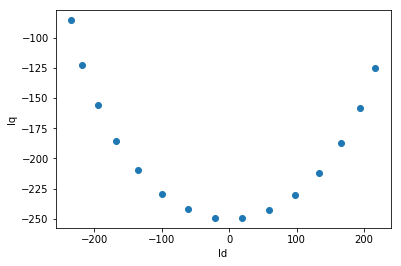

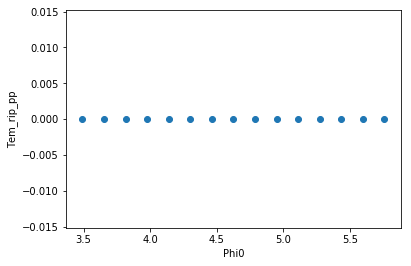

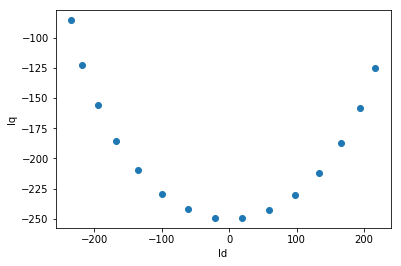

In [16]:
Xout.plot_multi("Phi0", "Tem_rip_pp")
Xout.plot_multi("Id", "Iq")


# To go further
Here are some other parameters to change the way things are done:
